# Prediccion de valor en la bolsa de valores

Version inicial 04/01/2021

El primer modelo, sera probrar con machine learning y sus algoritmos para predecir valores del mercado. Este primer codigo es gracias Vicent Tatan y a su blog https://towardsdatascience.com/in-12-minutes-stocks-analysis-with-pandas-and-scikit-learn-a8d8a7b50ee7

## Importando las librerias

In [ ]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame
import math
import numpy as np
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

start = datetime.datetime(2015, 1, 1)
end = datetime.datetime(2021, 1, 4)

df = web.DataReader("LTC-USD", 'yahoo', start, end)
df.tail()

In [ ]:
close_px = df['Adj Close']
mavg = close_px.rolling(window=300).mean()

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='AAPL')
mavg.plot(label='mavg')
plt.legend()

In [ ]:
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')

In [ ]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

In [ ]:
# Drop missing value
dfreg.fillna(value=-99999, inplace=True)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))
# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)
# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X_train = X[:-forecast_out]
# Separate label and identify it as y
y = np.array(dfreg['label'])
y_train = y[:-forecast_out]

In [ ]:
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)
# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

In [ ]:
forecast_set = clfknn.predict(X_lately)
dfreg['Forecast'] = np.nan

In [ ]:
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

## Mejoras propuestas al modelo: Usando RNN y LSTM

In [ ]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame
import math
import numpy as np
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn import preprocessing
import matplotlib.pyplot as plt

# Neural Network library
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import RMSprop
import math
import tensorflow as tf
from tensorflow.python.framework import ops
import sklearn.preprocessing


In [ ]:
start = datetime.datetime(2012, 1, 1)
end = datetime.datetime(2021, 1, 4)

df = web.DataReader("AAPL", 'yahoo', start, end)
df.tail()

In [ ]:
df = df.drop(['Volume','Adj Close'], axis=1)
cols = list(df.columns.values)
print('df_stock.columns.values = ', cols)


## Escalando los valores y encontrando train-validations-test sets (v1)

In [ ]:
data_scale = MinMaxScaler(feature_range=(0,1))
df_scale = data_scale.fit_transform(np.array(df).reshape(-1,1))

In [ ]:
df_scale.shape

In [ ]:
train_size = int(len(df_scale)*0.65)
test_size = len(df_scale) - train_size
train_data, test_data = df_scale[0:train_size,:],df_scale[train_size:len(df_scale),:1]

In [ ]:
train_size,test_size

Transformando en una matriz 

In [ ]:
def dataset(data,time_step=1):
    X,y = [],[]
    for i in range (len(data)-time_step-1):
        a = data[i:(i+time_step),0]
        X.append(a)
        y.append(data[i + time_step,0])
    return np.array(X), np.array(y)

In [ ]:
steps = 60
X_train, y_train = dataset(train_data,steps)
X_test, y_test = dataset(test_data,steps)

In [ ]:
X_train

Vamos a hacer un reshape a los datos

In [ ]:
#[samples, time_steps, features]
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [ ]:
X_train.shape

In [ ]:
features = X_train.shape[2]

lstm_model=Sequential()
lstm_model.add(LSTM(units=100,activation='tanh',return_sequences=True,input_shape=(X_train.shape[1],features)))
lstm_model.add(LSTM(units=60,activation='tanh', return_sequences=True))
lstm_model.add(LSTM(units=10))
lstm_model.add(Dense(features))

lstm_model.compile(loss='mean_squared_error',optimizer='adam',metrics=['accuracy'])

In [ ]:
lstm_model.summary()


In [ ]:
res = lstm_model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs = 30,batch_size = 64, verbose=1)


## Escalando los valores y encontrando train-validations-test sets (v2)

In [ ]:
# function for min-max normalization of stock
# split data in 80%/10%/10% train/validation/test sets
valid_set_size_percentage = 20 
test_set_size_percentage = 10 
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df['Open'].values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df['High'].values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df['Low'].values.reshape(-1,1))
    df['close'] = min_max_scaler.fit_transform(df['Close'].values.reshape(-1,1))
    return df

# function to create train, validation, test data given stock data and sequence length
def load_data(stock, seq_len):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

# normalize stock
#df_stock_norm = df.copy()
#df_stock_norm = normalize_data(df_stock_norm)

# create train, test data
seq_len = 100 # choose sequence length
data_scale = MinMaxScaler(feature_range=(0,1))

new_data = data_scale.fit(df[['Close']])
df = pd.DataFrame(data_scale.fit_transform(df), columns=df.columns, index=df.index)
df = df.dropna()


x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df, seq_len)

print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

In [ ]:
df

In [ ]:
plt.figure(figsize=(15, 5));
plt.plot(df['Open'], color='red', label='open')
plt.plot(df['Close'], color='green', label='Close')
plt.plot(df['Low'], color='blue', label='low')
plt.plot(df['High'], color='black', label='high')
#plt.plot(df_stock_norm.volume.values, color='gray', label='volume')
plt.title('stock')
plt.xlabel('time [days]')
plt.ylabel('normalized price/volume')
plt.legend(loc='best')
plt.show()

In [ ]:

lstm_model=Sequential()
lstm_model.add(LSTM(units=70,activation='tanh',return_sequences=True,input_shape=(X_train.shape[1],features)))
lstm_model.add(LSTM(units=80,activation='tanh'))
lstm_model.add(Dense(features))


lstm_model.compile(loss='mean_squared_error',optimizer='adamax',metrics=['accuracy'])
res = lstm_model.fit(X_train,y_train,epochs=20,batch_size=128,verbose=1,validation_split=0.2)


In [ ]:
score = lstm_model.evaluate(X_test, y_test, verbose=1)
predicted_closing_price=lstm_model.predict(X_test)
#predicted_closing_price=data_scale.inverse_transform(predicted_closing_price)

In [ ]:
predicted_closing_price=data_scale.inverse_transform(predicted_closing_price)

In [ ]:
predicted_closing_price[2]

In [ ]:
print()
print('Test loss:', round(score[0], 3))
print('Test accuracy:', round(score[1]*100, 3))

In [ ]:
plt.plot(predicted_closing_price[2])

In [ ]:
    history = res.history
    plt.figure(figsize=(16,5))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure(figsize=(16,5))
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

In [ ]:
plt.figure(figsize=(15, 5));
plt.plot(df['Close'], color='green', label='Close')
plt.plot(predicted_closing_price[2], color='black', label='Close Predicte')

plt.title('stock')
plt.xlabel('time [days]')
plt.ylabel('normalized price/volume')
plt.legend(loc='best')
plt.show()

## Version 3

In [2]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame
import math
import numpy as np
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn import preprocessing
import matplotlib.pyplot as plt

# Neural Network library
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import RMSprop
import math
import tensorflow as tf
from tensorflow.python.framework import ops
import sklearn.preprocessing
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM


Using TensorFlow backend.


In [50]:
start = datetime.datetime(2012, 1, 1)
end = datetime.datetime(2021, 1, 5)

df = web.DataReader("AAPL", 'yahoo', start, end)
df.tail()
#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

In [51]:
df.tail(200)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-03-23,57.125000,53.152500,57.020000,56.092499,336752800.0,55.744217
2020-03-24,61.922501,58.575001,59.090000,61.720001,287531200.0,61.336773
2020-03-25,64.562500,61.075001,62.687500,61.380001,303602000.0,60.998886
2020-03-26,64.669998,61.590000,61.630001,64.610001,252087200.0,64.208832
2020-03-27,63.967499,61.762501,63.187500,61.935001,204216800.0,61.550438
...,...,...,...,...,...,...
2020-12-29,138.789993,134.339996,138.050003,134.869995,121047300.0,134.869995
2020-12-30,135.990005,133.399994,135.580002,133.720001,96452100.0,133.720001
2020-12-31,134.740005,131.720001,134.080002,132.690002,98990400.0,132.690002


In [28]:
#new_data['Date'][0]
new_data = df.drop(['High','Low','Open','Volume','Adj Close'],axis=1)

In [29]:
new_data

,Close
Date,
2012-01-03,14.686786
2012-01-04,14.765715
2012-01-05,14.929643
2012-01-06,15.085714
2012-01-09,15.061786
...,...
2020-12-29,134.869995
2020-12-30,133.720001
2020-12-31,132.690002


In [30]:
def create_dataset(new_data):
    #creating train and test sets
    dataset = new_data.values

    train = dataset[0:987,:]
    valid = dataset[987:,:]

    #converting dataset into x_train and y_train
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)

    x_train, y_train = [], []
    for i in range(60,len(train)):
        x_train.append(scaled_data[i-60:i,0])
        y_train.append(scaled_data[i,0])
    x_train, y_train = np.array(x_train), np.array(y_train)

    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
    return x_train,y_train,valid,scaler

def create_predict_data(new_data):
    #predicting 246 values, using past 60 from the train data
    inputs = new_data[len(new_data) - len(valid) - 60:].values
    inputs = inputs.reshape(-1,1)
    inputs  = scaler.transform(inputs)

    X_test = []
    for i in range(60,inputs.shape[0]):
        X_test.append(inputs[i-60:i,0])
    X_test = np.array(X_test)

    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    return X_test

In [31]:
x_train, y_train,valid,scaler = create_dataset(new_data)

In [32]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=70, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])
model.fit(x_train, y_train, epochs=2, batch_size=1, verbose=1)

Epoch 1/2
927/927 [==============================] - 228s 246ms/step - loss: 1.1927e-04 - accuracy: 0.0011
Epoch 2/2
927/927 [==============================] - 265s 286ms/step - loss: 4.7967e-05 - accuracy: 0.0011


In [33]:
X_test = create_predict_data(new_data)
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

In [34]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))

In [35]:
rms

1.8293885983527245

In [36]:
# save model and architecture to single file
if rms<3.1:
    model.save("model_ac31.h5")
    print("Saved model to disk")

Saved model to disk


In [37]:
closing_price

array([[ 29.789434],
       [ 29.798584],
       [ 29.851877],
       ...,
       [132.08023 ],
       [132.0261  ],
       [131.04651 ]], dtype=float32)

/Users/joseguerra/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


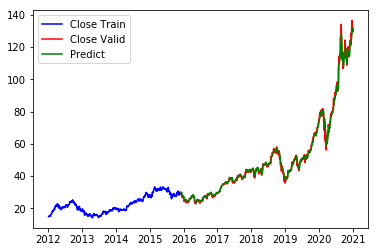

In [38]:
#for plotting
train = new_data[:987]
valid = new_data[987:]
valid['Predictions'] = closing_price
plt.plot(train['Close'], color='blue', label='Close Train')
plt.plot(valid['Close'], color='red',label='Close Valid')
plt.plot(valid['Predictions'], color='green',label='Predict')
plt.legend(loc='best')

In [45]:
start = datetime.datetime(2020, 1, 1)
end = datetime.datetime(2021, 1, 4)

df = web.DataReader("AAPL", 'yahoo', start, end)
df.tail()
new_data = df.drop(['High','Low','Open','Volume','Adj Close'],axis=1)

In [46]:
new_data

,Close
Date,
2020-01-02,75.087502
2020-01-03,74.357498
2020-01-06,74.949997
2020-01-07,74.597504
2020-01-08,75.797501
...,...
2020-12-28,136.690002
2020-12-29,134.869995
2020-12-30,133.720001


In [60]:
predict_data = create_predict_data(new_data)
n_features = new_data.shape[1]
print(n_features)
yhat = model.predict(np.array(new_data.tail(30)).reshape(1, 60, 1))

2


In [49]:
closing_price.shape

(194, 1)

In [57]:
new_data.shape

(2267, 2)